## 02 - Identificando os grupos etários com K-means: Kaggle Titanic

Exemplo de alternativa para identificação de grupos etários. O objetivo desse notebook é mostrar que o Machine Learning pode ser utilizado também no processo de limpeza de dados. É importante, porém, ter as etapas de limpeza e tratamento dos dados bem documentadas e passíveis de serem desfeitas, pois algoritmos diferentes podem performar melhor com diferentes estratégias de tratamento.

Este modelo serve mais como exemplo. Para a quantidade de dados no dataset e a facilidade de interpretação dos dados de idade isso poderia facilmente ser realizado manualmente ou com um código mais simples. O propósito aqui é exemplificar um uso.

## Preparando o ambiente

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [22]:
mpl.rcParams['figure.figsize'] = (12, 7)
sns.set_theme(style='darkgrid')

## Carregando os dados

In [23]:
titanic = pd.read_csv('../data/processed/train_processed.csv')
del titanic['Unnamed: 0']
titanic.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Embarked,Relateds
0,0,3,male,22,1,0,SC,S,1
1,1,1,female,38,1,0,C,C,1
2,1,3,female,26,0,0,SC,S,0
3,1,1,female,35,1,0,C,S,1
4,0,3,male,35,0,0,SC,S,0


In [24]:
idades, frequencia = np.unique(titanic.Age.values, return_counts=True)

## Visualizando as idades e frequencias

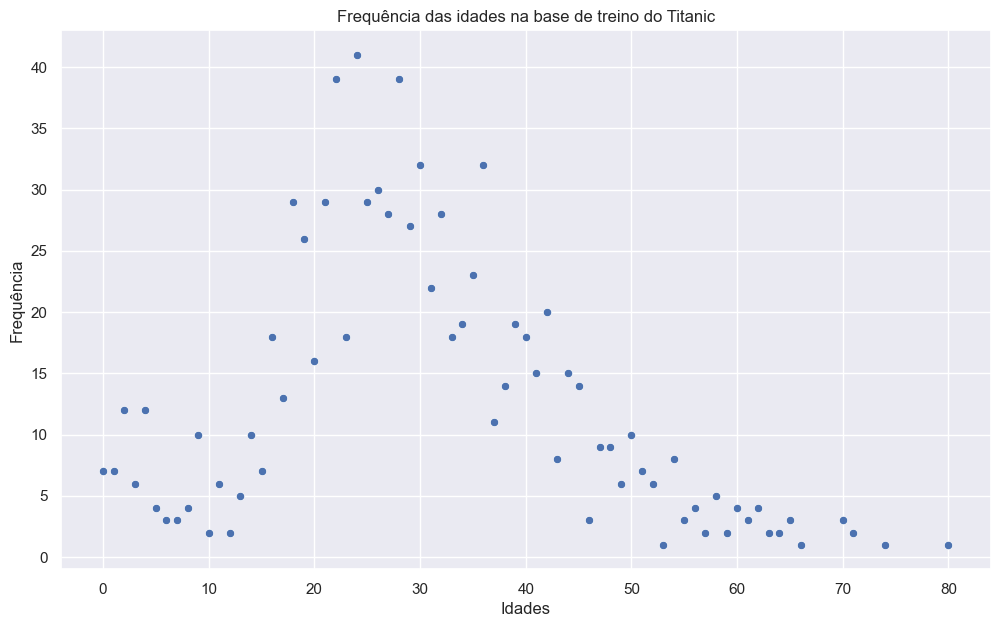

In [25]:
sns.scatterplot(x=idades, y=frequencia)
plt.xlabel('Idades')
plt.ylabel('Frequência')
plt.title('Frequência das idades na base de treino do Titanic')
plt.show();

## Criando os grupos

Utilizaremos um algoritmo de clusterização para separar as idades em grupos.

In [26]:
X = pd.DataFrame()
X['Idade'] = idades
X['Frequencia'] = frequencia
X

,Idade,Frequencia
0,0,7
1,1,7
2,2,12
3,3,6
4,4,12
...,...,...
66,66,1
67,70,3
68,71,2
69,74,1


Abaixo estamos realizando um "grid search" de forma explícita, ou seja, executando o mesmo algoritmo (`KMeans`) com diversas combinações de parâmetros e buscando o melhor. Para fins de exemplo, vários scores de análise de clusters estão sendo utilizados. Está além do escopo daqui explicar detalhadamente o funcionamento de cada um, mas o Scikit Learn possui as explicações matemáticas de cada um e a forma de interpretá-los.

In [27]:
n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
n_init = [10, 15, 20]
max_iter = [300, 500]
resultados = []
SEED = 42

for n in n_clusters:
    for i in n_init:
        for m in max_iter:
            agrupador = KMeans(n_clusters=n, n_init=i, max_iter=m, random_state=42)
            labels = agrupador.fit_predict(X)
            ss = silhouette_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            db = davies_bouldin_score(X, labels)
            values, counts = np.unique(labels, return_counts=True)
            r = {
                  'n_clusters': n,
                  'n_init': i,
                  'max_iter': m,
                  'Silhouette': ss,
                  'Calinski': ch,
                  'Bouldin':  db,
                  'counts': counts
            }
            resultados.append(r)

grupos = pd.DataFrame(data=resultados)

## Avaliando os modelos gerados

In [28]:
grupos.sort_values(by='Silhouette', ascending=False).head(5)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
6,3,10,300,0.572197,170.615465,0.568946,"[25, 28, 18]"
7,3,10,500,0.572197,170.615465,0.568946,"[25, 28, 18]"
8,3,15,300,0.572197,170.615465,0.568946,"[25, 28, 18]"
9,3,15,500,0.572197,170.615465,0.568946,"[25, 28, 18]"
10,3,20,300,0.572197,170.615465,0.568946,"[25, 28, 18]"


O coeficiente de silhueta é bom para dados com curvas no espaço.

In [29]:
grupos.sort_values(by='Calinski', ascending=False).head(5)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
47,9,20,500,0.441260,215.831435,0.652261,"[12, 11, 10, 11, 4, 4, 10, 6, 3]"
46,9,20,300,0.441260,215.831435,0.652261,"[12, 11, 10, 11, 4, 4, 10, 6, 3]"
45,9,15,500,0.441260,215.831435,0.652261,"[12, 11, 10, 11, 4, 4, 10, 6, 3]"
44,9,15,300,0.441260,215.831435,0.652261,"[12, 11, 10, 11, 4, 4, 10, 6, 3]"
43,9,10,500,0.418163,213.634690,0.718738,"[9, 12, 9, 10, 8, 5, 6, 9, 3]"


O Calinski não performa tão bem para dados com curva no espaço e com baixa densidade. Portanto não é a melhor métrica a ser usada para este dataset.

In [30]:
grupos.sort_values(by='Bouldin', ascending=True).head(5)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
6,3,10,300,0.572197,170.615465,0.568946,"[25, 28, 18]"
7,3,10,500,0.572197,170.615465,0.568946,"[25, 28, 18]"
8,3,15,300,0.572197,170.615465,0.568946,"[25, 28, 18]"
9,3,15,500,0.572197,170.615465,0.568946,"[25, 28, 18]"
10,3,20,300,0.572197,170.615465,0.568946,"[25, 28, 18]"


O Bouldin é baseado na semelhança dos elementos dentro do cluster e diferença entre os clusters, sendo melhor mas semelhante ao coeficiente de silhueta. Abaixo o melhor modelo. Ele inclui 3 clusters.

In [31]:
grupos.sort_values(by=['Silhouette', 'Bouldin', 'Calinski', 'n_init', 'max_iter'], ascending=[False, True, True, True, True]).head(1)

,n_clusters,n_init,max_iter,Silhouette,Calinski,Bouldin,counts
6,3,10,300,0.572197,170.615465,0.568946,"[25, 28, 18]"


## Executando o modelo selecionado

O melhor modelo agrupou as idades em 3 pela frequência, permitindo, a princípio, uma categorização mais justa com relação à distribuição dos dados.

In [32]:
agrupador = KMeans(n_clusters=3, n_init=10, max_iter=300)
labels = agrupador.fit_predict(X)
X['cod_faixa_etaria'] = labels
X.sample(10)

,Idade,Frequencia,cod_faixa_etaria
27,27,28,0
52,52,6,1
36,36,32,0
31,31,22,0
62,62,4,1
13,13,5,2
19,19,26,0
28,28,39,0
7,7,3,2
61,61,3,1


In [33]:
X.groupby('cod_faixa_etaria').Idade.describe()

,count,mean,std,min,25%,50%,75%,max
cod_faixa_etaria,,,,,,,,
0,26.0,30.538462,7.716117,18.0,24.25,30.5,36.75,44.0
1,27.0,57.740741,9.403733,43.0,50.50,57.0,63.50,80.0
2,18.0,8.500000,5.338539,0.0,4.25,8.5,12.75,17.0


**Faixas de idade identificadas:**

* _Criança/Adolescente_: 0 - 15
* _Jovem/Adulto_: 16 - 41
* _Adulto/Idoso_: 42 - 80

In [34]:
X.loc[(X['Idade'] == 16) | (X['Idade'] == 17), 'cod_faixa_etaria'] = 2
X.loc[(X['Idade'] == 16) | (X['Idade'] == 17)]

,Idade,Frequencia,cod_faixa_etaria
16,16,18,2
17,17,13,2


In [35]:
X.loc[(X['Idade'] == 42) | (X['Idade'] == 43), 'cod_faixa_etaria'] = 0
X.loc[(X['Idade'] == 42) | (X['Idade'] == 43)]

,Idade,Frequencia,cod_faixa_etaria
42,42,20,0
43,43,8,0


In [36]:
X.groupby('cod_faixa_etaria').Idade.describe()

,count,mean,std,min,25%,50%,75%,max
cod_faixa_etaria,,,,,,,,
0,27.0,31.000000,7.937254,18.0,24.50,31.0,37.50,44.0
1,26.0,58.307692,9.107225,45.0,51.25,57.5,63.75,80.0
2,18.0,8.500000,5.338539,0.0,4.25,8.5,12.75,17.0


In [37]:
map_idade = {
    0: 'adulto_idoso',
    1: 'crianca_adolescente',
    2: 'jovem_adulto'
}
titanic = (titanic.merge(X, left_on='Age', right_on='Idade')).drop(columns=['Idade', 'Frequencia'])
titanic['faixa_etaria'] = titanic.cod_faixa_etaria.map(map_idade)
titanic.sample(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Floor,Embarked,Relateds,cod_faixa_etaria,faixa_etaria
737,1,1,male,35,0,0,B,C,0,0,adulto_idoso
312,0,2,female,26,1,1,SC,S,2,0,adulto_idoso
749,0,3,male,31,0,0,SC,Q,0,0,adulto_idoso
422,0,3,male,29,0,0,SC,S,0,0,adulto_idoso
606,0,3,male,30,0,0,SC,S,0,0,adulto_idoso
5,0,3,male,38,0,0,SC,Q,0,0,adulto_idoso
561,0,3,male,40,0,0,SC,S,0,0,adulto_idoso
683,0,3,male,14,5,2,SC,S,7,2,jovem_adulto
331,0,1,male,45,0,0,C,S,0,1,crianca_adolescente
623,0,3,male,21,0,0,SC,S,0,0,adulto_idoso


## Visualizando os agrupamentos

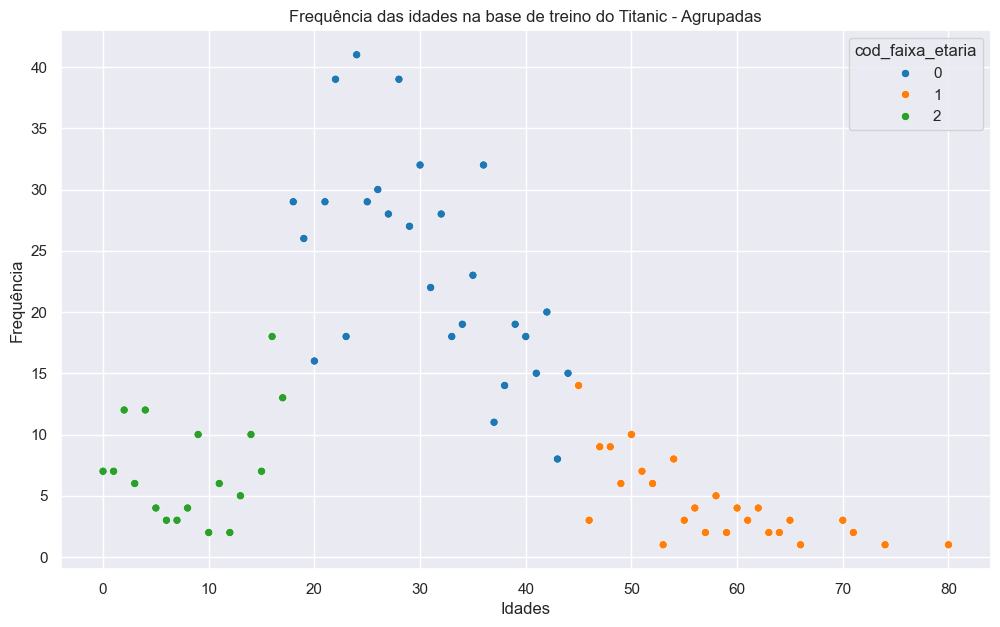

In [38]:
sns.scatterplot(x='Idade', y='Frequencia', data=X, hue='cod_faixa_etaria', palette="tab10")
plt.xlabel('Idades')
plt.ylabel('Frequência')
plt.title('Frequência das idades na base de treino do Titanic - Agrupadas')
plt.show();

In [39]:
del titanic['cod_faixa_etaria']

In [40]:
titanic.to_csv('../data/processed/train_processed_byage.csv')